In [1]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing.sequence import *
from keras.regularizers import *
from sklearn.metrics import f1_score, accuracy_score
from keras.callbacks import EarlyStopping
from imblearn.metrics import classification_report_imbalanced
from keras.optimizers import *
import datetime
from collections import Counter

import warnings

df = pd.read_csv('/home/melgazar9/Trading/Data/CL/CL_Training_Data_TD/CL_10min/CL_10min_FULL_2018-12-03.csv')
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize('utc').tz_convert('US/Central')
df.dropna(axis=0, inplace=True)
df['Actual10minHighMove'] = df['Prev10minHighMove'].shift(-1)
df['Actual10minLowMove'] = df['Prev10minLowMove'].shift(-1)
df.head(2)

Using TensorFlow backend.


,Prev10minMove,Prev10minRange,Prev10minHighMove,Prev10minLowMove,Prev10minVolume,Prev15minMove,Prev15minRange,Prev15minHighMove,Prev15minLowMove,Prev15minVolume,...,Prev1hR3_Change,Prev2hPP_Change,Prev2hS1_Change,Prev2hR1_Change,Prev2hS2_Change,Prev2hR2_Change,Prev2hS3_Change,Prev2hR3_Change,Actual10minHighMove,Actual10minLowMove
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 13:20:00-06:00,-0.10,0.19,0.08,-0.11,5650.0,0.16,0.34,0.33,-0.01,15858.0,...,0.093333,-0.773333,-1.166667,-0.466667,-1.473333,-0.073333,-1.866667,0.233333,0.15,0.00
2018-03-02 13:30:00-06:00,0.06,0.15,0.15,0.00,5032.0,-0.01,0.19,0.08,-0.11,8478.0,...,0.116667,-0.786667,-1.223333,-0.483333,-1.526667,-0.046667,-1.963333,0.256667,0.12,-0.12


In [2]:
df.shape

(24245, 210)

### Create feature for intraday or overnight

In [3]:
df.loc[df.between_time('06:00:00','15:00:00', include_start=False).index, 'Overnight_or_Intraday'] = 1
df['Overnight_or_Intraday'].fillna(0, inplace=True)

### Create a class that calculates the target variable - for 2 strategies (HL and Actual--Move)

In [4]:
class CalcTarget():
    
    def __init__(self, df, strong_buy, med_buy, no_trade, med_sell, strong_sell, threshold, stop):
        self.df = df
        self.strong_buy = strong_buy
        self.med_buy = med_buy
        self.no_trade = no_trade
        self.med_sell = med_sell
        self.strong_sell = strong_sell
        self.threshold = threshold
        self.stop = stop
        
    def calc_target_actual(self):
        super().__init__()
    
        self.df['Actual10minMove'] = self.df['Prev10minMove'].shift(-1)
    
        lst = []

        for move in self.df['Actual10minMove']:

            # strong buy
            if move >= self.strong_buy and move <= self.threshold:
                lst.append(4)

            # medium buy
            elif move >= self.med_buy and move <= self.strong_buy:
                lst.append(3)

            # no trade
            elif move <= self.med_buy and move >= self.med_buy * (-1):
                lst.append(2)

            # medium sell
            elif move <= self.med_sell * (-1) and move >= self.strong_sell * (-1):
                lst.append(1)

            elif move <= self.strong_sell * (-1) and move >= self.threshold * (-1):
                lst.append(0)

            else:
                lst.append('Error')

        return pd.DataFrame(lst, index=self.df.index).rename(columns={0:'Target_Actual'})
    
    def calc_target_HL(self):

        # stop means how much heat I am willing to take per trade
        # i.e. if the move went up in my favor $50 but I took $1000 worth of heat that isn't good
        # hm stands for high move, lm stands for low move

        lst = []

        i = 0
        while i < len(self.df):
            # if ActualHM >= buy signal AND ActualLM doesn't go below stop
            if self.df['Actual10minHighMove'][i] >= self.strong_buy and self.df['Actual10minLowMove'][i] >= (-1)*self.stop:
                lst.append(4)
                i+=1
            elif self.df['Actual10minLowMove'][i] <= (-1)*self.strong_sell and self.df['Actual10minHighMove'][i] <= self.stop:
                lst.append(0)
                i+=1
            elif self.df['Actual10minHighMove'][i] >= self.med_buy and self.df['Actual10minLowMove'][i] >= (-1)*self.stop:
                lst.append(3)
                i+=1
            elif self.df['Actual10minLowMove'][i] <= (-1)*self.med_sell and self.df['Actual10minHighMove'][i] <= self.stop:
                lst.append(1)
                i+=1
            else:
                lst.append(2)
                i+=1

        return pd.DataFrame(lst, index=self.df.index).rename(columns={0:'Target_HL'})

    




target_actual = CalcTarget(df, strong_buy=.35, med_buy=.15, no_trade=.15, 
                            med_sell=.15, strong_sell=.35, threshold=5, 
                            stop=.25).calc_target_actual()
target_actual = target_actual.replace('Error', 2)

target_HL = CalcTarget(df, strong_buy=.35, med_buy=.15, no_trade=.15, med_sell=.15, strong_sell=.35, threshold=5, stop=.25).calc_target_HL()#['Target'].value_counts()
print(target_actual['Target_Actual'].value_counts())
print(target_HL['Target_HL'].value_counts())

df['Target_Actual'] = target_actual
df['Target_HL'] = target_HL

df.head(2)

2    22180
3      895
1      892
0      159
4      119
Name: Target_Actual, dtype: int64
2    19790
1     1962
3     1935
0      316
4      242
Name: Target_HL, dtype: int64


,Prev10minMove,Prev10minRange,Prev10minHighMove,Prev10minLowMove,Prev10minVolume,Prev15minMove,Prev15minRange,Prev15minHighMove,Prev15minLowMove,Prev15minVolume,...,Prev2hS2_Change,Prev2hR2_Change,Prev2hS3_Change,Prev2hR3_Change,Actual10minHighMove,Actual10minLowMove,Overnight_or_Intraday,Actual10minMove,Target_Actual,Target_HL
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 13:20:00-06:00,-0.10,0.19,0.08,-0.11,5650.0,0.16,0.34,0.33,-0.01,15858.0,...,-1.473333,-0.073333,-1.866667,0.233333,0.15,0.00,1.0,0.06,2,2
2018-03-02 13:30:00-06:00,0.06,0.15,0.15,0.00,5032.0,-0.01,0.19,0.08,-0.11,8478.0,...,-1.526667,-0.046667,-1.963333,0.256667,0.12,-0.12,1.0,-0.04,2,2


In [5]:
print(df['Target_Actual'].value_counts())
print(df['Target_HL'].value_counts())

2    22180
3      895
1      892
0      159
4      119
Name: Target_Actual, dtype: int64
2    19790
1     1962
3     1935
0      316
4      242
Name: Target_HL, dtype: int64


# Data Cleaning

In [6]:
df[[i for i in df.columns if i.startswith('Actual')]].columns # must only have 'Actual10minMove', 'Actual10minHighMove', 'Actual10minLowMove'

Index(['Actual10minHighMove', 'Actual10minLowMove', 'Actual10minMove'], dtype='object')

### Create opinionated trades as features

In [7]:
# def create_features_opinionated_trades(df, features, strong_threshold, med_threshold):
    
#     lst = []
        
#     i = 0
#     for feature in features:
#         while i < len(df):
#             if df[feature][i] >= strong_threshold: # strong buy
#                 lst.append(4)
#                 i+=1
#             elif df[feature][i] >= med_threshold: # medium buy
#                 lst.append(3)
#                 i+=1
#             elif df[feature][i] <= (-1)*med_threshold:
#                 lst.append(1)
#                 i+=1
#             elif df[feature][i] <= (-1)*strong_threshold:
#                 lst.append(0)
#                 i+=1
#             else:
#                 lst.append(2)
#                 i+=1
                
#         feature_i = pd.DataFrame(lst, index=df.index, columns=[str(feature)[4:] + 'Opinion'])
#         df = pd.concat([df, feature_i], axis=1)
    
#     return df

# # create_features_opinionated_trades(df=df, features=[i for i in df.columns if not i.startswith('Actual') and
# #                                                     i.endswith('Move')], strong_threshold=.3, med_threshold=.2)
# df = create_features_opinionated_trades(df=df, features=['Prev10minMove', 'Prev15minMove', 'Prev30minMove', 
#                                                          'Prev1hMove', 'Prev2hMove', 'Prev10minHighMove', 'Prev15minHighMove', 
#                                                          'Prev30minHighMove', 'Prev1hHighMove', 'Prev2hHighMove',
#                                                          'Prev10minLowMove', 'Prev15minLowMove', 'Prev30minLowMove', 
#                                                          'Prev1hLowMove', 'Prev2hLowMove'], 
#                                         strong_threshold=.3, med_threshold=.2)
# df.columns

### Convert dtypes to continuous and categorical features

In [8]:
df.get_dtype_counts()

bool         7
float64    197
int64       10
dtype: int64

In [9]:
cat_vars = ['Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'IsMonthEnd', 
           'IsMonthStart', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsHoliday',
           'IsYearStart', 'Overnight_or_Intraday', 'Hour', 'Quarter']

cat_vars = cat_vars + [i for i in df.columns if i.endswith('Binned') or i.endswith('Opinion')]

cont_vars = [i for i in df.columns if not i in cat_vars]

print(len(df.columns) == len(cat_vars)+len(cont_vars)) # must be True!

train = df['2018-03-02':'2018-10-31']
test = df['2018-11-01':]
print(train.shape, test.shape)

joined = train[cat_vars+cont_vars].copy()
joined_test = test[cat_vars+cont_vars].copy()
joined.head()

True
(21532, 214) (2713, 214)


,Year,Month,Week,Day,DayofWeek,DayofYear,IsMonthEnd,IsMonthStart,IsQuarterEnd,IsQuarterStart,...,Prev2hR1_Change,Prev2hS2_Change,Prev2hR2_Change,Prev2hS3_Change,Prev2hR3_Change,Actual10minHighMove,Actual10minLowMove,Actual10minMove,Target_Actual,Target_HL
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 13:20:00-06:00,2018,3,9,2,4,61,False,False,False,False,...,-0.466667,-1.473333,-0.073333,-1.866667,0.233333,0.15,0.00,0.06,2,2
2018-03-02 13:30:00-06:00,2018,3,9,2,4,61,False,False,False,False,...,-0.483333,-1.526667,-0.046667,-1.963333,0.256667,0.12,-0.12,-0.04,2,2
2018-03-02 13:40:00-06:00,2018,3,9,2,4,61,False,False,False,False,...,-0.496667,-1.413333,-0.113333,-1.796667,0.153333,0.01,-0.13,-0.06,2,2
2018-03-02 13:50:00-06:00,2018,3,9,2,4,61,False,False,False,False,...,-0.373333,-1.426667,0.073333,-1.873333,0.376667,0.02,-0.04,0.01,2,2
2018-03-02 14:00:00-06:00,2018,3,9,2,4,61,False,False,False,False,...,0.326667,-1.216667,0.703333,-1.593333,1.286667,0.05,-0.02,0.04,2,2


In [10]:
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

joined.shape, joined_test.shape

((21532, 214), (2713, 214))

### FILL CATEGORICAL NAN VALUES WITH CORRECT VALUES
'Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'Hour', 'Quarter'

In [11]:
joined_test['Year'] = joined_test.index.year.astype('category')
joined_test['Month'] = joined_test.index.month.astype('category')
joined_test['Week'] = joined_test.index.week.astype('category')
joined_test['Day'] = joined_test.index.day.astype('category')
joined_test['DayofWeek'] = joined_test.index.dayofweek.astype('category')
joined_test['DayofYear'] = joined_test.index.dayofyear.astype('category')
joined_test['Hour'] = joined_test.index.hour.astype('category')
joined_test['Quarter'] = joined_test.index.quarter.astype('category')

# pd.concat([joined[cat_feats_fill], joined_test[cat_feats_fill]], axis=0)
joined_test['Month'].value_counts()

11    2713
Name: Month, dtype: int64

#### fastai 'apply_cats' changes any columns of strings in df into categorical variables using trn as a template for the category codes.

In [12]:
# apply_cats(joined_test, joined)

### Fill Continuous Variables using backfill

In [13]:
for v in cont_vars:
    joined[v] = joined[v].bfill().astype('float32')
    joined_test[v] = joined_test[v].bfill().astype('float32')

print(joined.isnull().any()[joined.isnull().any()!=False], '\n')
print(joined_test.isnull().any()[joined_test.isnull().any()!=False])

print(joined.get_dtype_counts())
print(joined_test.get_dtype_counts())

Series([], dtype: bool) 

Actual10minHighMove    True
Actual10minLowMove     True
Actual10minMove        True
dtype: bool
category     16
float32     198
dtype: int64
category     16
float32     198
dtype: int64


In [14]:
df['Actual10minHighMove'].isnull().sum()

1

In [15]:
joined.select_dtypes('category').columns

Index(['Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'IsMonthEnd',
       'IsMonthStart', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd',
       'IsHoliday', 'IsYearStart', 'Overnight_or_Intraday', 'Hour', 'Quarter'],
      dtype='object')

### Convert category columns to category data types

In [16]:
gc.collect()

7

In [17]:
# for col in joined[[i for i in joined.columns if i.endswith('Binned')]]:
#     joined[col] = joined[col].astype('category').cat.codes
    
# for col in joined_test[[i for i in joined_test.columns if i.endswith('Binned')]]:
#     joined_test[col] = joined_test[col].astype('category').cat.codes
    
# print(joined.get_dtype_counts())
# print(joined_test.get_dtype_counts())

### Assign df to be the concatenation (stacked) of joined and joined_test
Train test split this dataframe after embedding the categorical columns

In [18]:
df = pd.concat([joined, joined_test], axis=0)

In [19]:
df['DayofWeek'].value_counts()

3    4977
1    4966
2    4964
4    4712
0    4530
6      96
Name: DayofWeek, dtype: int64

### One-hot encode the features

In [20]:
df = pd.get_dummies(df, columns=[i for i in cat_vars], drop_first=True)
df.rename(columns={'Overnight_or_Intraday_1.0':'Overnight_or_Intraday'}, inplace=True)
cat_vars = [i for i in df.columns if not i in cont_vars]

for col in cat_vars:
    df[col] = df[col].astype('category').cat.as_ordered()
    
for col in cont_vars:
    df[col] = df[col].astype('float32')

df.get_dtype_counts()

category    311
float32     198
dtype: int64

# Data Preparation
### Train Test Split

In [21]:
def time_series_split(train_start_date, train_end_date, val_start_date, val_end_date, test_start_date, HL):

    X = df.drop(['Actual10minMove', 'Actual10minHighMove', 'Actual10minLowMove', 'Target_Actual', 'Target_HL'], axis=1)
    y_actual = df['Target_Actual']
    y_HL = df['Target_HL']

    X.sort_index(inplace=True)
    y_actual.sort_index(inplace=True)
    y_HL.sort_index(inplace=True)

    X_train = X[train_start_date:train_end_date]
    X_val = X[val_start_date:val_end_date]
    X_test = X[test_start_date:]

    y_train_actual = y_actual[train_start_date:train_end_date]
    y_val_actual = y_actual[val_start_date:val_end_date]
    y_test_actual = y_actual[test_start_date:]
    
    y_train_HL = y_HL[train_start_date:train_end_date]
    y_val_HL = y_HL[val_start_date:val_end_date]
    y_test_HL = y_HL[test_start_date:]

    y_test_actual.fillna(2, inplace=True)
    y_test_HL.fillna(2, inplace=True)
    
    if HL==False:
        print(X_train.shape, X_val.shape, X_test.shape, y_train_actual.shape, y_val_actual.shape, y_test_actual.shape)
        return X_train, X_val, X_test, y_train_actual, y_val_actual, y_test_actual
    
    elif HL==True:
        print(X_train.shape, X_val.shape, X_test.shape, y_train_HL.shape, y_val_HL.shape, y_test_HL.shape)
        return X_train, X_val, X_test, y_train_HL, y_val_HL, y_test_HL

X_train, X_val, X_test, y_train_actual, y_val_actual, y_test_actual = time_series_split(train_start_date='2018-03-01', train_end_date='2018-08-31',
                                                                                        val_start_date='2018-09-01', val_end_date='2018-10-31',
                                                                                        test_start_date='2018-11-01', HL=False)

X_train, X_val, X_test, y_train_HL, y_val_HL, y_test_HL = time_series_split(train_start_date='2018-03-01', train_end_date='2018-08-31',
                                                                                        val_start_date='2018-09-01', val_end_date='2018-10-31',
                                                                                        test_start_date='2018-11-01', HL=True)


(16145, 504) (5387, 504) (2713, 504) (16145,) (5387,) (2713,)
(16145, 504) (5387, 504) (2713, 504) (16145,) (5387,) (2713,)


In [22]:
X_train.get_dtype_counts(), X_val.get_dtype_counts(), X_test.get_dtype_counts()

(category    311
 float32     193
 dtype: int64, category    311
 float32     193
 dtype: int64, category    311
 float32     193
 dtype: int64)

In [23]:
cont_vars = [i for i in cont_vars if not i.startswith('Target') and not i.startswith('Actual')]

### Scale data

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler().fit(np.array(X_train))

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# for col in df.select_dtypes('uint8').columns:
for col in cat_vars:
    #print(col)
    X_train_scaled[col] = X_train_scaled[col].astype('category').cat.as_ordered()
    X_val_scaled[col] = X_val_scaled[col].astype('category').cat.as_ordered()
    X_test_scaled[col] = X_test_scaled[col].astype('category').cat.as_ordered()
    
for col in cont_vars:
    #print(col)
    X_train_scaled[col] = X_train_scaled[col].astype('float32')
    X_val_scaled[col] = X_val_scaled[col].astype('float32')
    X_test_scaled[col] = X_test_scaled[col].astype('float32')
    
print(X_train_scaled.get_dtype_counts())
print(X_val_scaled.get_dtype_counts())
print(X_test_scaled.get_dtype_counts())
X_train_scaled.head(2)

/home/melgazar9/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


category    311
float32     193
dtype: int64
category    311
float32     193
dtype: int64
category    311
float32     193
dtype: int64


,Prev10minMove,Prev10minRange,Prev10minHighMove,Prev10minLowMove,Prev10minVolume,Prev15minMove,Prev15minRange,Prev15minHighMove,Prev15minLowMove,Prev15minVolume,...,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Quarter_2,Quarter_3,Quarter_4
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 13:20:00-06:00,0.601810,0.115854,0.064516,0.923077,0.058121,0.695067,0.157895,0.253846,0.995122,0.117943,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-02 13:30:00-06:00,0.674208,0.091463,0.120968,1.000000,0.051760,0.618834,0.086124,0.061538,0.946341,0.063055,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### One hot encode target variable before training

In [25]:
# y_oh_actual = keras.utils.to_categorical(y_actual, num_classes=5)
# y_oh_HL = keras.utils.to_categorical(y_oh_HL, num_classes=5)


y_train_oh_actual = keras.utils.to_categorical(y_train_actual, num_classes=5)
y_val_oh_actual = keras.utils.to_categorical(y_val_actual, num_classes=5)
y_test_oh_actual = keras.utils.to_categorical(y_test_actual, num_classes=5)

y_train_oh_HL = keras.utils.to_categorical(y_train_HL, num_classes=5)
y_val_oh_HL = keras.utils.to_categorical(y_val_HL, num_classes=5)
y_test_oh_HL = keras.utils.to_categorical(y_test_HL, num_classes=5)

y_train_oh_actual, y_train_oh_HL

(array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=float32), array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]], dtype=float32))

# Machine Learning
### Train XGBOOST before diving into deep learning - find if there are any features causing cheating

In [26]:
from xgboost import XGBClassifier, plot_importance
warnings.filterwarnings('ignore')
from sklearn.metrics import *
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

class TrainModel():
    
    def __init__(self, model, X_train_fit, y_train_fit, X_val_fit, y_val_fit, 
                 X_test_unseen, y_test_unseen, need_cont_vars, plot_importances=False, NN=False,
                 batch_size=None, epochs=None):
        
        self.model = model
        self.X_train_fit = X_train_fit
        self.y_train_fit = y_train_fit
        self.X_val_fit = X_val_fit
        self.y_val_fit = y_val_fit
        self.X_test_unseen = X_test_unseen
        self.y_test_unseen = y_test_unseen
        self.need_cont_vars = need_cont_vars
        self.plot_importances = plot_importances
        self.NN = NN
        self.batch_size = batch_size
        self.epochs = epochs
#         self.validation_split = validation_split
#         self.early_stopping = early_stopping
#         self.shuffle = shuffle
#         self.validation_data = validation_data
#         self.class_weight = class_weight
#         self.sample_weight = sample_weight
#         self.validation_steps = validation_steps
#         self.verbose = verbose
    
    
    def plot_feature_importances_traditional(self):
        
        super().__init__()

        features = self.X_train_fit.columns
        importances = self.model.feature_importances_
        indices = np.argsort(importances)

        plt.figure(figsize=(30, 150))
        plt.title('Feature Importances')
        plt.barh(y=range(len(indices)), width=importances[indices], height=.5, color='c', align='center')
        plt.yticks(ticks=range(len(indices)), labels=[features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

        return
    
    def train_model(self):

        super().__init__()
        
        if self.need_cont_vars == True:
                self.X_train_fit = self.X_train_fit.astype('float32')
                self.X_val_fit = self.X_val_fit.astype('float32')
                self.X_test_unseen = self.X_test_unseen.astype('float32')

        
            
        if self.NN == False:    
            
            self.model.fit(self.X_train_fit, self.y_train_fit)
        
            X_train_fit_predictions = self.model.predict(self.X_train_fit)
            X_val_fit_predictions = self.model.predict(self.X_val_fit)
            X_test_unseen_predictions = self.model.predict(self.X_test_unseen)
            
            print('Train Accuracy:', accuracy_score(X_train_fit_predictions, self.y_train_fit))
            print('Val Accuracy:', accuracy_score(X_val_fit_predictions, self.y_val_fit))
            print('Test Accuracy:', accuracy_score(X_test_unseen_predictions, self.y_test_unseen))

            print('Train F1:', f1_score(X_train_fit_predictions, self.y_train_fit, average='weighted'))
            print('Val F1:', f1_score(X_val_fit_predictions, self.y_val_fit, average='weighted'))
            print('Test F1:', f1_score(X_test_unseen_predictions, self.y_test_unseen, average='weighted'))

            print('Train:', classification_report_imbalanced(X_train_fit_predictions, self.y_train_fit))
            print('Val:', classification_report_imbalanced(X_val_fit_predictions, self.y_val_fit))
            print('Test:', classification_report_imbalanced(X_test_unseen_predictions, self.y_test_unseen))

            if self.plot_importances == True:
                self.plot_feature_importances_traditional()
                
        elif self.NN == True:
            
            print(model.summary)
            
            self.model.fit(self.X_train_fit, self.y_train_fit, self.batch_size, self.epochs)
            
            X_train_fit_predictions = self.model.predict(self.X_train_fit).argmax(axis=-1)
            X_val_fit_predictions = self.model.predict(self.X_val_fit).argmax(axis=-1)
            X_test_unseen_predictions = self.model.predict(self.X_test_unseen).argmax(axis=-1)
            
            y_train_reversed = self.y_train_fit.argmax(axis=-1)
            y_val_reversed = self.y_val_fit.argmax(axis=-1)
            y_test_reversed = self.y_test_unseen.argmax(axis=-1)

            print('Train Accuracy:', accuracy_score(X_train_fit_predictions, y_train_reversed))
            print('Val Accuracy:', accuracy_score(X_val_fit_predictions, y_val_reversed))
            print('Test Accuracy:', accuracy_score(X_test_unseen_predictions, y_test_reversed))

            print('Train F1:', f1_score(X_train_fit_predictions, y_train_reversed, average='weighted'))
            print('Val F1:', f1_score(X_val_fit_predictions, y_val_reversed, average='weighted'))
            print('Test F1:', f1_score(X_test_unseen_predictions, y_test_reversed, average='weighted'))

            print('Train:', classification_report_imbalanced(X_train_fit_predictions, y_train_reversed))
            print('Val:', classification_report_imbalanced(X_val_fit_predictions, y_val_reversed))
            print('Test:', classification_report_imbalanced(X_test_unseen_predictions, y_test_reversed))
            
        
        return self.model

In [27]:
class CalcResults():

    def __init__(self, model, X, y, predictions, stop, strong_cap, med_cap, multiplier, need_cont_vars, HL, PredProb_ON=True, NN=False):
        
        self.model = model
        self.X = X
        self.y = y
        self.predictions = predictions
        self.stop = stop
        self.strong_cap = strong_cap
        self.med_cap = med_cap
        self.multiplier = multiplier
        self.need_cont_vars = need_cont_vars
        self.HL = HL
        self.PredProb_ON = PredProb_ON
        self.NN = NN
    
    def calc_predictions(self):
        
        super().__init__()
        
        if self.NN == False:
            probs = self.model.predict_proba(self.X)
        elif self.NN == True:
            probs = self.model.predict(self.X)

        lst=[]

        for p in probs:
            if p[2] == max(p):
                lst.append(2)
            elif p[0] >= .5 and p[0] >= max(p):
                lst.append(0)
            elif p[1] >= .5 and p[1] >= max(p):
                lst.append(1)
            elif p[3] >= .5 and p[3] >= max(p):
                lst.append(3)
            elif p[4] >= .5 and p[4] >= max(p):
                lst.append(4)
            else:
                lst.append(2)
        
        return lst
    
    def initialize_df(self):
        
        super().__init__()

        if self.need_cont_vars == True:
            self.X = self.X.astype('float32')
        
        if self.PredProb_ON == False:
            if self.NN == False:
                pred = pd.DataFrame(self.model.predict(self.X), index=self.X.index).rename(columns={0:self.predictions})
            elif self.NN == True:
                pred = pd.DataFrame(self.model.predict(self.X).argmax(axis=-1), index=self.X.index).rename(columns={0:self.predictions})
        
        elif self.PredProb_ON == True:
            pred = pd.DataFrame(self.calc_predictions(), index=self.X.index).rename(columns={0:self.predictions})
        
        if self.HL == False:
            if self.NN == False:
                results = pd.concat([pd.DataFrame(self.y, index=self.X.index), pred], axis=1).rename(columns={0:'Target_Actual'})
            elif self.NN == True:
                results = pd.concat([pd.DataFrame(self.y.argmax(axis=-1), index=self.X.index), pred], axis=1).rename(columns={0:'Target_Actual'})
        elif self.HL == True:
            if self.NN == False:
                results = pd.concat([pd.DataFrame(self.y, index=self.X.index), pred], axis=1).rename(columns={0:'Target_HL'})            
            elif self.NN == True:
                results = pd.concat([pd.DataFrame(self.y.argmax(axis=-1), index=self.X.index), pred], axis=1).rename(columns={0:'Target_HL'})            
                
        results = pd.concat([results, pd.DataFrame(df['Actual10minHighMove'], index=pred.index), 
                             pd.DataFrame(df['Actual10minLowMove'], index=pred.index), 
                             pd.DataFrame(df['Actual10minMove'], index=pred.index)], axis=1)

        return results
    
    def calc_pnl_onelot_actual(self):
        
        super().__init__()
        
        results = self.initialize_df()
        
        print('Actual Move Results')

        lst=[]

        i=0
        while i < len(results):

            # strong buy -> 2 contracts traded
            if results[self.predictions][i] == 4:
                if results['Actual10minLowMove'][i] > (-1)*self.stop: # not stopped out
                    if results['Actual10minHighMove'][i] >= self.strong_cap:
                        lst.append(1*self.strong_cap)
                        i+=1
                    else:
                        lst.append(1*results['Actual10minMove'][i])
                        i+=1
                elif results['Actual10minLowMove'][i] <= (-1)*self.stop: # stopped out
                    lst.append((-1)*self.stop) # -.02 for assuming a trade out -> i.e. selling at the bid horribly (worst case testing)
                    i+=1
                else:
                    print('Error1')
                    lst.append(np.nan)
                    i+=1

            # medium buy
            elif results[self.predictions][i] == 3:
                if results['Actual10minLowMove'][i] > (-1)*self.stop:
                    if results['Actual10minHighMove'][i] >= self.med_cap:
                        lst.append(self.med_cap)
                        i+=1
                    else:
                        lst.append(results['Actual10minMove'][i])
                        i+=1
                elif results['Actual10minLowMove'][i] <= (-1)*self.stop:
                    lst.append((-1)*self.stop)
                    i+=1
                else:
                    print('Error2')
                    lst.append(np.nan)
                    i+=1

            # no trade
            elif results[self.predictions][i] == 2:
                lst.append(0)
                i+=1

            # medium sell
            elif results[self.predictions][i] == 1:
                if results['Actual10minHighMove'][i] < self.stop:
                    if results['Actual10minLowMove'][i] <= (-1)*self.med_cap:
                        lst.append(self.med_cap)
                        i+=1
                    else:
                        lst.append((-1) * results['Actual10minMove'][i])
                        i+=1
                elif results['Actual10minHighMove'][i] >= self.stop:
                    lst.append((-1)*self.stop)
                    i+=1
                else:
                    print('Error3')
                    lst.append(np.nan)
                    i+=1

            # strong sell
            elif results[self.predictions][i] == 0:
                if results['Actual10minHighMove'][i] < self.stop:
                    if results['Actual10minLowMove'][i] <= (-1)*self.strong_cap:
                        lst.append(1*self.strong_cap)
                        i+=1
                    else:
                        lst.append((-1) * results['Actual10minMove'][i])
                        i+=1
                elif results['Actual10minHighMove'][i] >= self.stop:
                    lst.append((-1)*self.stop)
                    i+=1
                else:
                    print('Error5')
                    lst.append(np.nan)
                    i+=1
            else:
                lst2.append('Error6')
                lst.append(np.nan)
                i+=1

        pnl = pd.DataFrame(lst, index=results.index).rename(columns={0:self.predictions.split(' ')[0] + ' P/L Actual'})
        results = pd.concat([results, pnl], axis=1)
        results.sort_index(inplace=True)
        
        print('Trade Pct Predicted Actual:', float(len(results[results[self.predictions]!=2])) / len(results))
        print('Trade Pct Actual Target Actual', float(len(results[results['Target_Actual']!=2])) / len(results))        
        print(self.predictions + ' P/L BEFORE FEES Actual:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L Actual'])*self.multiplier))
        print(self.predictions + ' P/L AFTER FEES Actual:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L Actual'])*self.multiplier) - float((7)*len(results.loc[results[self.predictions]!=2]))) # subtract fees
        
        dataset_name = self.predictions.split(' ')[0]
        
        pnl_4 = results[results[dataset_name + ' Predictions']==4]
        pnl_3 = results[results[dataset_name + ' Predictions']==3]
        pnl_1 = results[results[dataset_name + ' Predictions']==1]
        pnl_0 = results[results[dataset_name + ' Predictions']==0]
        
        print(dataset_name + ' Class 4:', pnl_4[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
        print(dataset_name + ' Class 3:', pnl_3[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
        print(dataset_name + ' Class 1:', pnl_1[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
        print(dataset_name + ' Class 0:', pnl_0[self.predictions.split(' ')[0] + ' P/L Actual'].sum()*self.multiplier)
                
        return results
    
    
    def calc_pnl_2to1_actual(self):

        super().__init__()
        results = self.initialize_df()
        
        print('Actual Move Results')
        # Concat results into dataframe with columns: Target, Predictions, Actual Move
        
        if self.NN == False:
            pred = pd.DataFrame(model.predict(self.X), index=self.X.index).rename(columns={0:self.predictions})
            results = pd.concat([pd.DataFrame(self.y, index=self.X.index), pred], axis=1).rename(columns={0:'Target_Actual'})
            results = pd.concat([results, pd.DataFrame(self.df['Actual10minMove'], index=self.X.index)], axis=1)
        elif self.NN == True:
            pred = pd.DataFrame(model.predict(self.X).argmax(axis=-1), index=self.X.index).rename(columns={0:self.predictions})
            results = pd.concat([pd.DataFrame(self.y.argmax(axis=-1), index=self.X.index), pred], axis=1).rename(columns={0:'Target_Actual'})
            results = pd.concat([results, pd.DataFrame(self.df['Actual10minMove'], index=self.X.index)], axis=1)

        # Calculate P/L and concat it as an additional column
        lst=[]

        i=0
        while i < len(results):

            # strong buy -> 2 contracts traded
            if results[self.predictions][i] == 4:
                lst.append(1*results['Actual10minMove'][i])
                i+=1

            # medium buy
            elif results[self.predictions][i] == 3:
                lst.append(results['Actual10minMove'][i])
                i+=1

            # no trade
            elif results[self.predictions][i] == 2:
                lst.append(0)
                i+=1

            # medium sell
            elif results[self.predictions][i] == 1:
                lst.append((-1) * results['Actual10minMove'][i])
                i+=1

            # strong sell
            elif results[self.predictions][i] == 0:
                lst.append((-1) * results['Actual10minMove'][i])
                i+=1

            else:
                lst.append('Error')
                i+=1

        pnl = pd.DataFrame(lst, index=results.index).rename(columns={0:self.predictions.split(' ')[0] + ' P/L HL'}) 
        results = pd.concat([results, pnl], axis=1)

        print(self.predictions + ' P/L HL BEFORE FEES:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier))
        print(self.predictions + ' P/L HL AFTER FEES:', float(np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier) - float((7)*len(results.loc[results[self.predictions]!=2]))) # subtract fees

        return results.sort_index()
                
    def calc_pnl_onelot_HL(self):

        super().__init__()
        results = self.initialize_df()
        
        print('HL Results')
        # Calculate P/L and concat it as an additional column
        lst=[]
#         lst2=[]
        i=0
        while i < len(results):

            # strong buy -> 2 contracts traded
            if results[self.predictions][i] == 4:
                if results['Actual10minLowMove'][i] >= (-1)*self.stop: # not stopped out
                    if results['Actual10minHighMove'][i] >= self.strong_cap:
#                         lst2.append(1)
                        lst.append(self.strong_cap) # take profit at strong_cap
                        i+=1
                    else:
#                         lst2.append(2)
                        lst.append(results['Actual10minMove'][i])
                        i+=1
                else: # stopped out
#                     lst2.append(3)
                    lst.append((-1)*self.stop) # Assume additional loss of 2 ticks for being stopped out
                    i+=1

            # med buy -> 1 contract traded
            elif results[self.predictions][i] == 3:
                if results['Actual10minLowMove'][i] >= (-1)*self.stop: # not stopped out
                    if results['Actual10minHighMove'][i] >= self.med_cap:
#                         lst2.append(4)
                        lst.append(self.med_cap) # take profit at med_cap
                        i+=1
                    else:
#                         lst2.append(5)
                        lst.append(results['Actual10minMove'][i])
                        i+=1
                else: # stopped out
#                     lst2.append(6)
                    lst.append((-1)*self.stop) # Assume additional loss of 1 tick for being stopped out
                    i+=1


            elif results[self.predictions][i] == 2:
#                 lst2.append(7)
                lst.append(0)
                i+=1

            # med sell
            elif results[self.predictions][i] == 1:
                if results['Actual10minHighMove'][i] <= self.stop: # not stopped out
                    if results['Actual10minLowMove'][i] <= (-1)*self.med_cap:
#                         lst2.append(8)
                        lst.append(self.med_cap) # take profit at med_cap
                        i+=1
                    else:
                        lst.append((-1)*results['Actual10minMove'][i])
#                         lst2.append(9)
                        i+=1
                else:
                    lst.append((-1)*self.stop)
#                     lst2.append(10)
                    i+=1

            # strong sell
            elif results[self.predictions][i] == 0:
                if results['Actual10minHighMove'][i] <= self.stop:
                    if results['Actual10minLowMove'][i] <= (-1)*self.strong_cap:
#                         lst2.append(11)
                        lst.append((1)*self.strong_cap) # take profit
                        i+=1
                    else:
#                         lst2.append(12)
                        lst.append((-1)*results['Actual10minMove'][i])
                        i+=1

                else:
#                     lst2.append(13)
                    lst.append((-1)*self.stop)
                    i+=1

            else:
#                 lst2.append('error')
                lst.append('Error')
                i+=1

        pnl = pd.DataFrame(lst, index=results.index).rename(columns={0:self.predictions.split(' ')[0] + ' P/L HL'}) 
#         results = pd.concat([results, pnl, pd.DataFrame(lst2, index=results.index)], axis=1)
        results = pd.concat([results, pnl], axis=1)
        results.sort_index(inplace=True)
        
        print('Trade Pct Predicted HL:', float(len(results[results[self.predictions]!=2])) / len(results))
        print('Trade Pct Actual Target HL', float(len(results[results['Target_HL']!=2])) / len(results))
        print(self.predictions + ' P/L HL BEFORE FEES:', np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier)
        print(self.predictions + ' P/L HL AFTER FEES:', np.sum(results[self.predictions.split(' ')[0] + ' P/L HL'])*self.multiplier - (7)*len(results.loc[results[self.predictions]!=2])) # subtract fees
        
        dataset_name = self.predictions.split(' ')[0]
        
        pnl_4 = results[results[dataset_name + ' Predictions']==4]
        pnl_3 = results[results[dataset_name + ' Predictions']==3]
        pnl_1 = results[results[dataset_name + ' Predictions']==1]
        pnl_0 = results[results[dataset_name + ' Predictions']==0]
        
        print(dataset_name + ' Class 4:', pnl_4[dataset_name + ' P/L HL'].sum()*self.multiplier)
        print(dataset_name + ' Class 3:', pnl_3[dataset_name + ' P/L HL'].sum()*self.multiplier)
        print(dataset_name + ' Class 1:', pnl_1[dataset_name + ' P/L HL'].sum()*self.multiplier)
        print(dataset_name + ' Class 0:', pnl_0[dataset_name + ' P/L HL'].sum()*self.multiplier)
        
        return results
    
    
    def calc_profitability(self):
    
        if self.HL == False:
            prediction_df = self.calc_pnl_onelot_actual()

        elif self.HL == True:
            prediction_df = self.calc_pnl_onelot_HL()
        
        results = prediction_df[prediction_df[self.predictions] != 2]
    
        sell_lst = []
        buy_lst = []

        if self.HL == False:
            
            i=0
            while i < len(results):
                if results[self.predictions][i] >= 3 and results['Actual10minMove'][i] > 0:
                    buy_lst.append(1)
                    i+=1
                elif results[self.predictions][i] >= 3 and results['Actual10minMove'][i] <= 0:
                    buy_lst.append(0)
                    i+=1
                elif results[self.predictions][i] <= 1 and results['Actual10minMove'][i] < 0:
                    sell_lst.append(1)
                    i+=1
                elif results[self.predictions][i] <= 1 and results['Actual10minMove'][i] >= 0:
                    sell_lst.append(0)
                    i+=1
                else:
                    sell_lst.append('Error')
                    i+=1
                    
            plt.figure(figsize=(26,8))
            plt.plot(results.index, results[self.predictions.split(' ')[0] + ' P/L Actual'].cumsum())


        if self.HL == True:

            # Below: the result is not really too accurate but it will suffice. 
            # The actual rate will be better because the low move can happen before we get stopped out. 
            # I just assume if the stop target is hit we get stopped out, but that's not reality

            i=0
            while i < len(results):
                if results[self.predictions][i] >= 3 and ((results['Actual10minMove'][i] > 0 and results['Actual10minLowMove'][i] > (-1)*self.stop) or 
                                                          (results['Actual10minHighMove'][i] > self.strong_cap and results['Actual10minLowMove'][i] > (-1)*self.stop)):
                    buy_lst.append(1)
                    i+=1
                elif results[self.predictions][i] >= 3 and (results['Actual10minMove'][i] <= 0 or results['Actual10minLowMove'][i] <= (-1)*self.stop):
                    buy_lst.append(0)
                    i+=1
                elif results[self.predictions][i] <= 1 and ((results['Actual10minMove'][i] < 0 and results['Actual10minHighMove'][i] <= self.stop) or 
                                                            (results['Actual10minLowMove'][i] <= (-1)*self.strong_cap and results['Actual10minHighMove'][i] <= self.stop)):
                    sell_lst.append(1)
                    i+=1
                elif results[self.predictions][i] <= 1 and (results['Actual10minMove'][i] >= 0 or results['Actual10minHighMove'][i] >= self.stop):
                    sell_lst.append(0)
                    i+=1
                else:
                    sell_lst.append('Error')
                    i+=1

            plt.figure(figsize=(26,8))
            plt.plot(results.index, results[self.predictions.split(' ')[0] + ' P/L HL'].cumsum())

                    
        try:
            print('Buy Accuracy:', float(Counter(buy_lst)[1]) / len(buy_lst))
            print('Sell Accuracy:', float(Counter(sell_lst)[1]) / len(sell_lst))
            print('\n')
        except ZeroDivisionError:
            print('Zero Division Error. Could not divide by 0.')
            print('\n')
            
            
        return results
    

    def calc_sharpe(self, results):

        super().__init__()

        dataset_name = self.predictions.split(' ')[0]

        if self.HL == True:
            sharpe_HL = np.sum(results[results[self.predictions]!=2][dataset_name + ' P/L HL'] / (np.sqrt(len(results[results[self.predictions] != 2])*results[results[self.predictions] !=2][dataset_name + ' P/L HL'].std())))
            print('HL Sharpe:', sharpe_HL)
            print('\n')
        if self.HL == False:
            sharpe_actual = np.sum(results[results[self.predictions]!=2][dataset_name + ' P/L Actual'] / (np.sqrt(len(results[results[self.predictions] != 2])*results[results[self.predictions] !=2][dataset_name + ' P/L Actual'].std())))
            print('Actual Sharpe:', sharpe_actual)
            print('\n')

        return


    def calc_results(self):
        
        super().__init__()

        self.initialize_df()
        results = self.calc_profitability().astype('float32')
        self.calc_sharpe(results)

        return results

### SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

def create_smote_df(HL, need_cont_vars=False, scale=False):
    
    sm = SMOTE(n_jobs=32, random_state=0)
    if HL == False:
        X_temp = pd.concat([X_train, X_val], axis=0)
        y_temp = pd.concat([y_train_actual, y_val_actual], axis=0)
        X_resampled, y_resampled = sm.fit_sample(X_temp, y_temp)
        print('Original dataset shape:', Counter(y_temp))
    
    elif HL == True:
        X_temp = pd.concat([X_train, X_val], axis=0)
        y_temp = pd.concat([y_train_HL, y_val_HL], axis=0) 
        X_resampled, y_resampled = sm.fit_sample(X_temp, y_temp)
        print('Original dataset shape:', Counter(y_temp))
    
    print('Resampled dataset shape:', Counter(y_resampled))

    X_train_smote = pd.DataFrame(X_resampled, columns=X_train.columns).iloc[0:int(len(X_resampled)*.7)]
    X_val_smote = pd.DataFrame(X_resampled, columns=X_train.columns).iloc[int(len(X_resampled)*.7):]
    y_train_smote = pd.Series(y_resampled).iloc[0:int(len(y_resampled)*.7)]
    y_val_smote = pd.Series(y_resampled).iloc[int(len(y_resampled)*.7):]
    
    if need_cont_vars == True:
        X_train_smote = X_train_smote.astype('float32')
        X_val_smote = X_val_smote.astype('float32')
    
    if need_cont_vars != True:
        for col in cat_vars:
            X_train_smote[col] = X_train_smote[col].astype('category').cat.as_ordered()
            X_val_smote[col] = X_val_smote[col].astype('category').cat.as_ordered()
        for col in cont_vars:
            X_train_smote[col] = X_train_smote[col].astype('float32')
            X_val_smote[col] = X_val_smote[col].astype('float32')

    if scale == True:
        X_train_smote_scaled = pd.DataFrame(scaler.transform(X_train_smote), columns=X_train_scaled.columns)
        X_val_smote_scaled = pd.DataFrame(scaler.transform(X_val_smote), columns=X_val_scaled.columns)

    if HL == False:
        print(X_train_smote.shape, X_val_smote.shape, X_test.shape, y_train_smote.shape, y_val_smote.shape, y_test_actual.shape)
    elif HL == True:
        print(X_train_smote.shape, X_val_smote.shape, X_test.shape, y_train_smote.shape, y_val_smote.shape, y_test_HL.shape)
    
    print(X_train_smote.get_dtype_counts(), X_val_smote.get_dtype_counts())
    
    return X_train_smote, X_val_smote, y_train_smote, y_val_smote

# Model Evaluation
### Actual raw

Train Accuracy: 0.887147723753484
Val Accuracy: 0.8210506775570818
Test Accuracy: 0.6855879100626613
Train F1: 0.914274456733836
Val F1: 0.8889846265803395
Test F1: 0.7879475272292076
Train:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.53      1.00      1.00      0.69      1.00      1.00        89
        1.0       0.28      0.99      0.95      0.44      0.97      0.94       321
        2.0       1.00      0.88      1.00      0.94      0.94      0.87     15332
        3.0       0.27      0.98      0.95      0.43      0.96      0.93       335
        4.0       0.53      1.00      1.00      0.69      1.00      1.00        68

avg / total       0.97      0.89      0.99      0.91      0.94      0.87     16145

Val:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      0.99      0.00      0.00      0.00         2
        1.0       0.04      0.30      0.92      0.07 

,Target_HL,Test Predictions,Actual10minHighMove,Actual10minLowMove,Actual10minMove,Test P/L HL
Datetime,,,,,,


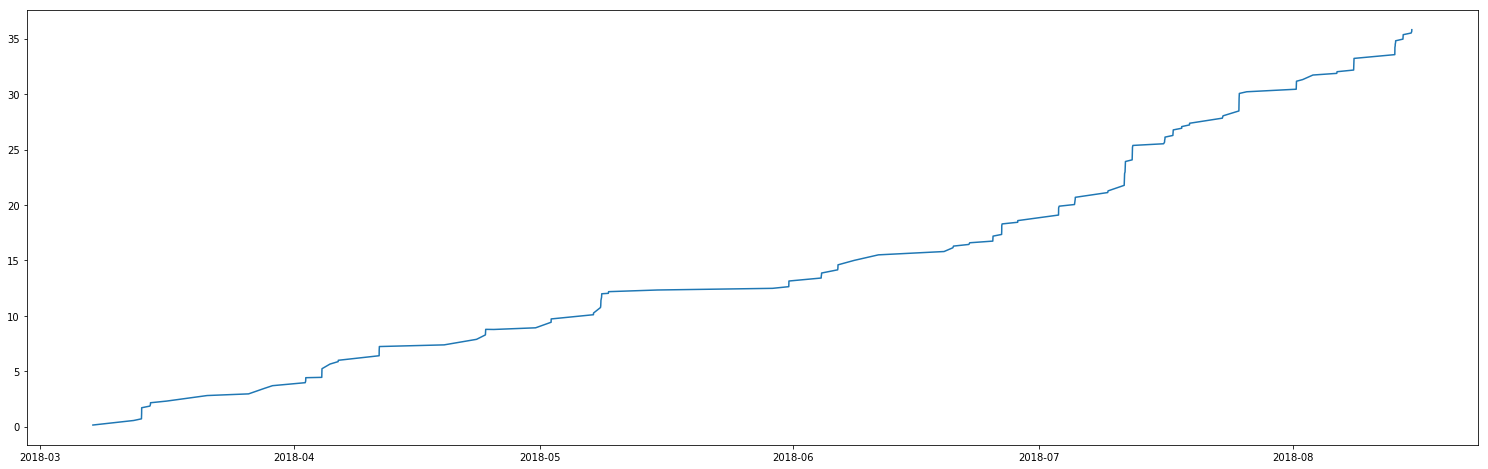

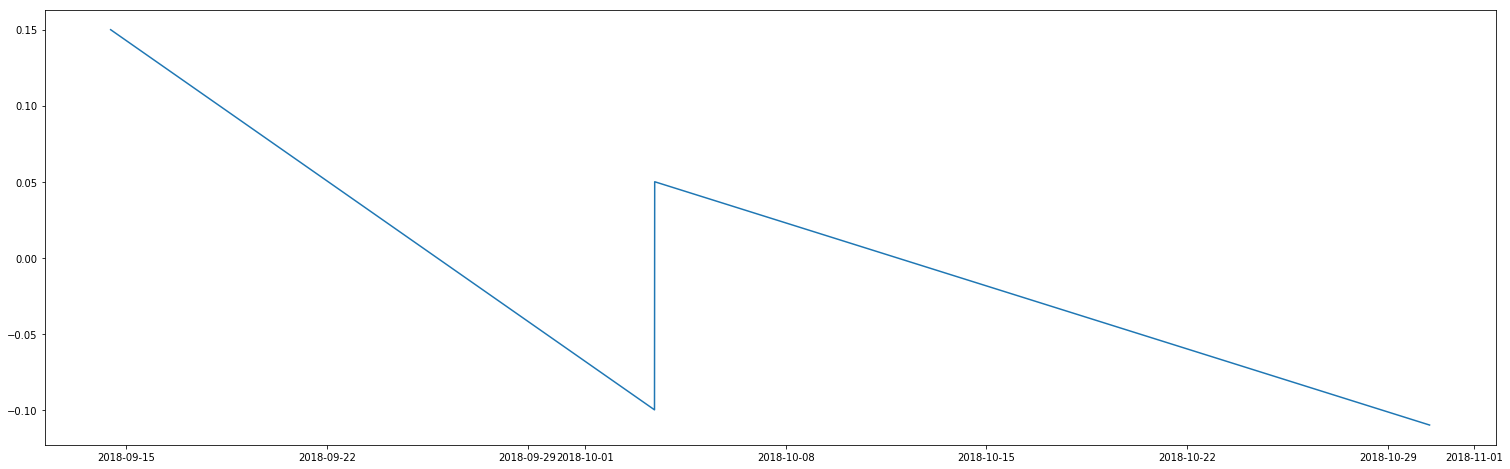

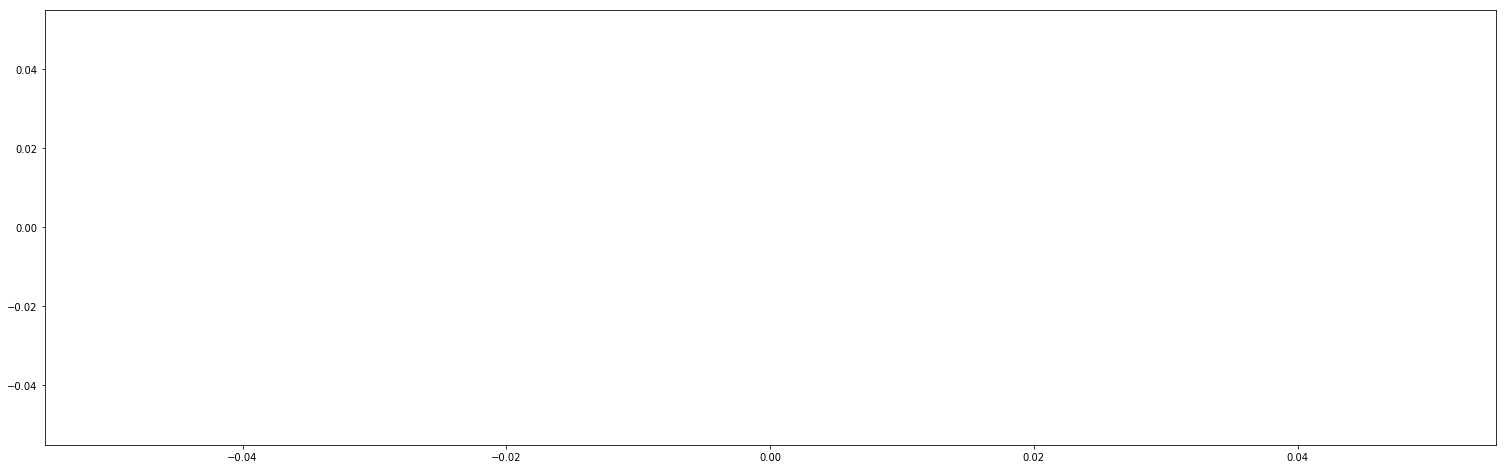

In [29]:
lgbmc = TrainModel(LGBMClassifier(learning_rate=.03, subsample=.8, max_depth=15, num_classes=5,
                                                        objective='multiclass:softmax', metric='multi_logloss',
                                                        sub_feature=.5, num_leaves=50, min_data=10, n_jobs=32), 
                   X_train, y_train_HL, X_val, y_val_HL, 
                   X_test, y_test_HL, need_cont_vars=False).train_model()

CalcResults(lgbmc, X_train, y_train_HL, 'Train Predictions', .25, .5, .15, 1000, False, True).calc_results()
CalcResults(lgbmc, X_val, y_val_HL, 'Val Predictions', .25, .5, .15, 1000, False, True).calc_results()
CalcResults(lgbmc, X_test, y_test_HL, 'Test Predictions', .25, .5, .15, 1000, False, True).calc_results()

### Actual SMOTE

In [30]:
X_train_smote, X_val_smote, y_train_smote_actual, y_val_smote_actual = create_smote_df(HL=False, need_cont_vars=False)
print(X_train_smote.shape, X_val_smote.shape, y_train_smote_actual.shape, y_val_smote_actual.shape)

Original dataset shape: Counter({2.0: 19871, 3.0: 744, 1.0: 712, 0.0: 111, 4.0: 94})
Resampled dataset shape: Counter({2.0: 19871, 3.0: 19871, 1.0: 19871, 0.0: 19871, 4.0: 19871})
(69548, 504) (29807, 504) (2713, 504) (69548,) (29807,) (2713,)
category    311
float32     193
dtype: int64 category    311
float32     193
dtype: int64
(69548, 504) (29807, 504) (69548,) (29807,)


Train Accuracy: 0.9142318973946052
Val Accuracy: 0.17207367396920187
Test Accuracy: 0.8105418356063399
Train F1: 0.9227112335663474
Val F1: 0.14413044164311306
Test F1: 0.841871735186713
Train:                    pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.96      1.00      0.98      0.98      0.95     20750
        1.0       0.95      0.85      0.98      0.90      0.91      0.82     22200
        2.0       0.99      0.92      1.00      0.95      0.96      0.91     21367
        3.0       0.52      0.99      0.93      0.69      0.96      0.92      5212
        4.0       0.20      1.00      1.00      0.34      1.00      1.00        19

avg / total       0.94      0.91      0.99      0.92      0.95      0.90     69548

Val:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      1.00      0.00      0.00      0.00      3937
        1.0       0.00      0.00      1.00      0.

,Target_Actual,Test Predictions,Actual10minHighMove,Actual10minLowMove,Actual10minMove,Test P/L Actual
Datetime,,,,,,
2018-11-02 08:20:00-05:00,3.0,0.0,0.22,-0.18,0.21,-0.21


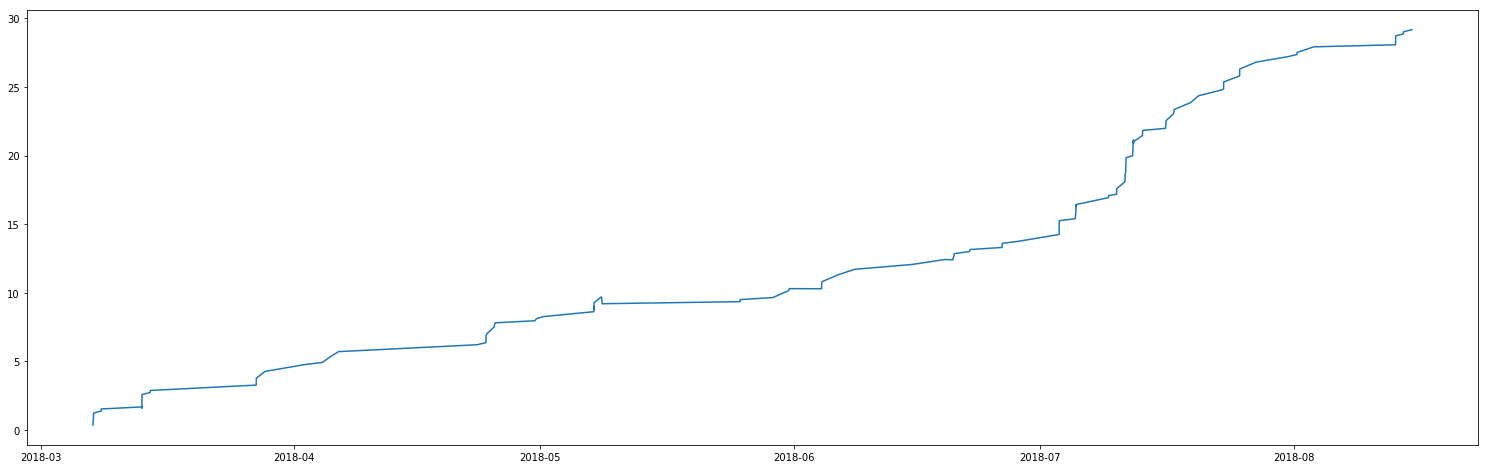

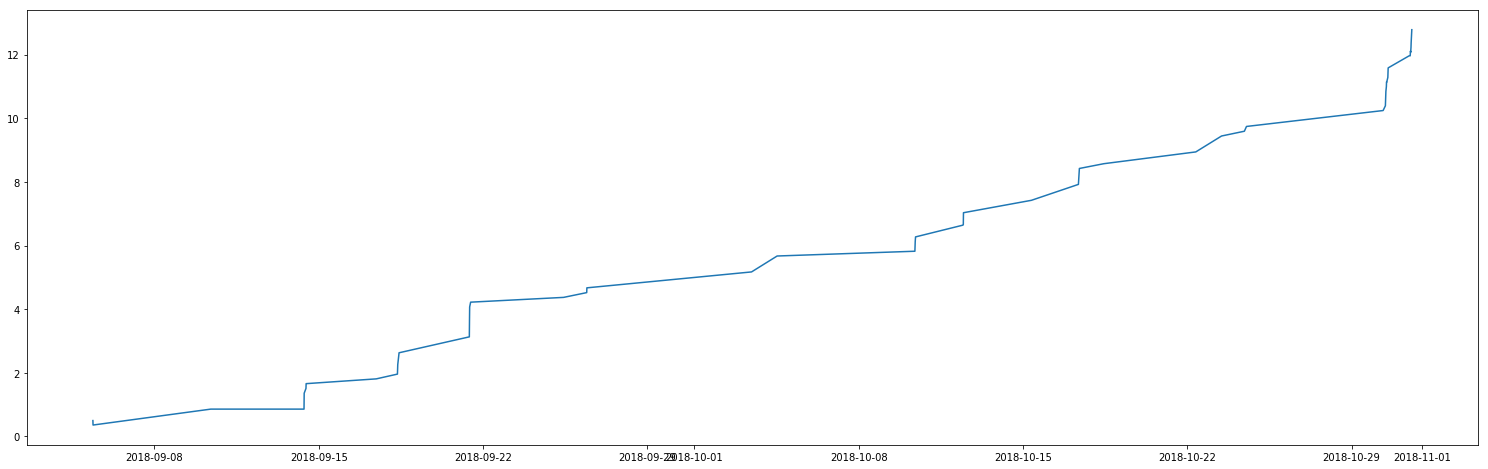

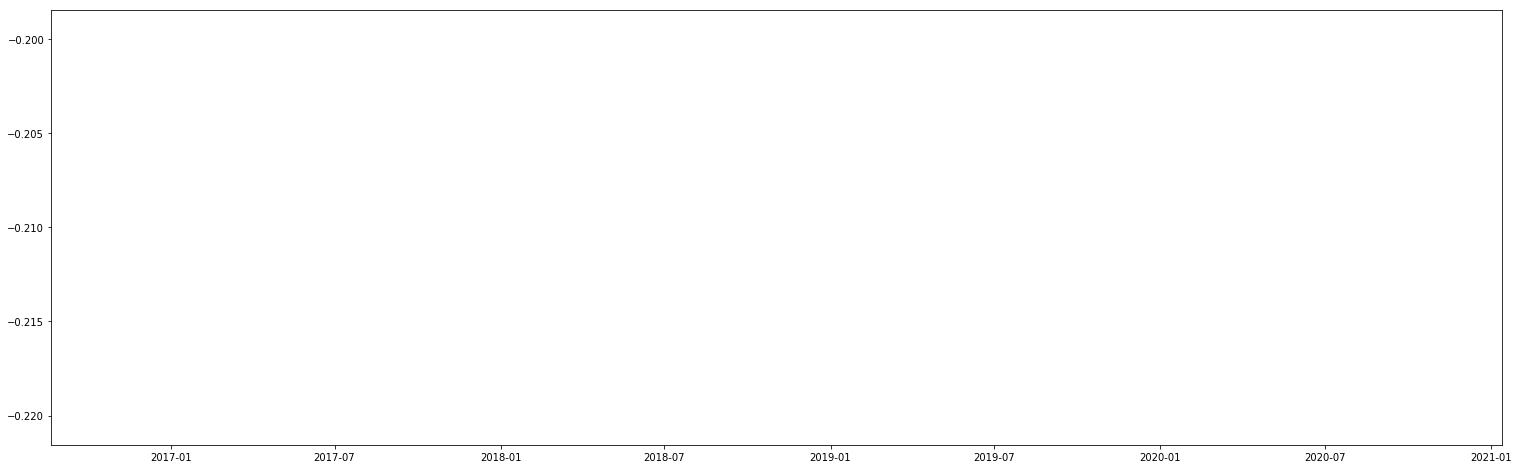

In [31]:
smote_lgbmc_actual = TrainModel(LGBMClassifier(learning_rate=.03, subsample=.8, max_depth=15, num_classes=5,
                                            objective='multiclass:softmax', metric='multi_logloss',
                                            sub_feature=.5, num_leaves=50, min_data=10, n_jobs=32), 
                             X_train_smote, y_train_smote_actual, X_val_smote, y_val_smote_actual, 
                             X_test, y_test_actual, need_cont_vars=False, plot_importances=False).train_model()

CalcResults(smote_lgbmc_actual, X_train, y_train_actual, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=False).calc_results()
CalcResults(smote_lgbmc_actual, X_val, y_val_actual, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=False).calc_results()
CalcResults(smote_lgbmc_actual, X_test, y_test_actual, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=False).calc_results()

### HL Raw

Train Accuracy: 0.887147723753484
Val Accuracy: 0.8210506775570818
Test Accuracy: 0.6855879100626613
Train F1: 0.914274456733836
Val F1: 0.8889846265803395
Test F1: 0.7879475272292076
Train:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.53      1.00      1.00      0.69      1.00      1.00        89
        1.0       0.28      0.99      0.95      0.44      0.97      0.94       321
        2.0       1.00      0.88      1.00      0.94      0.94      0.87     15332
        3.0       0.27      0.98      0.95      0.43      0.96      0.93       335
        4.0       0.53      1.00      1.00      0.69      1.00      1.00        68

avg / total       0.97      0.89      0.99      0.91      0.94      0.87     16145

Val:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      0.99      0.00      0.00      0.00         2
        1.0       0.04      0.30      0.92      0.07 

,Target_HL,Test Predictions,Actual10minHighMove,Actual10minLowMove,Actual10minMove,Test P/L HL
Datetime,,,,,,


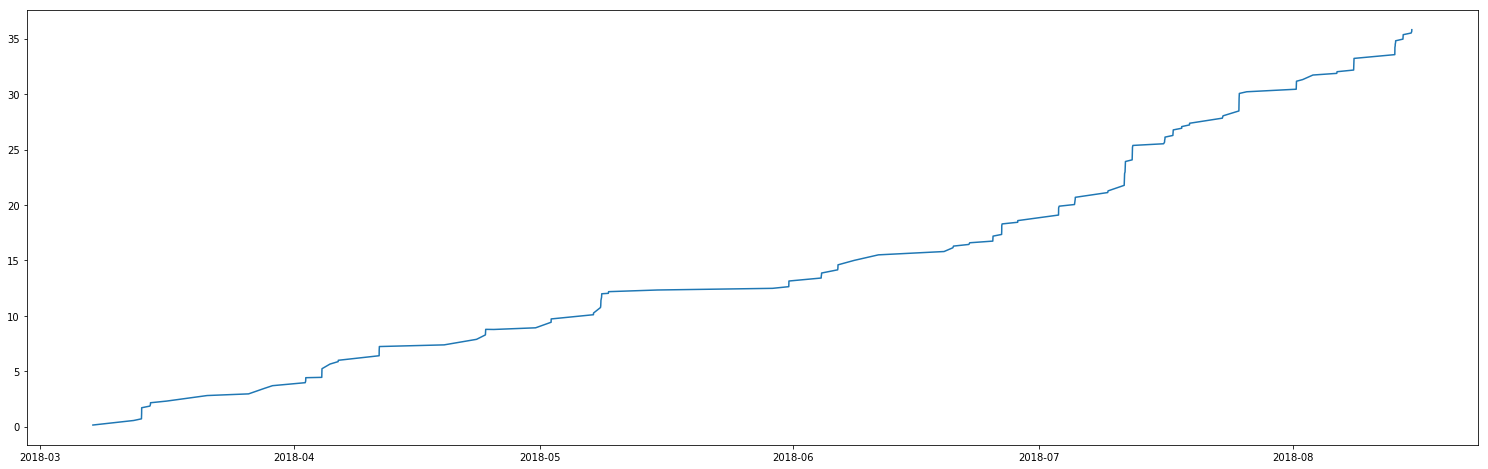

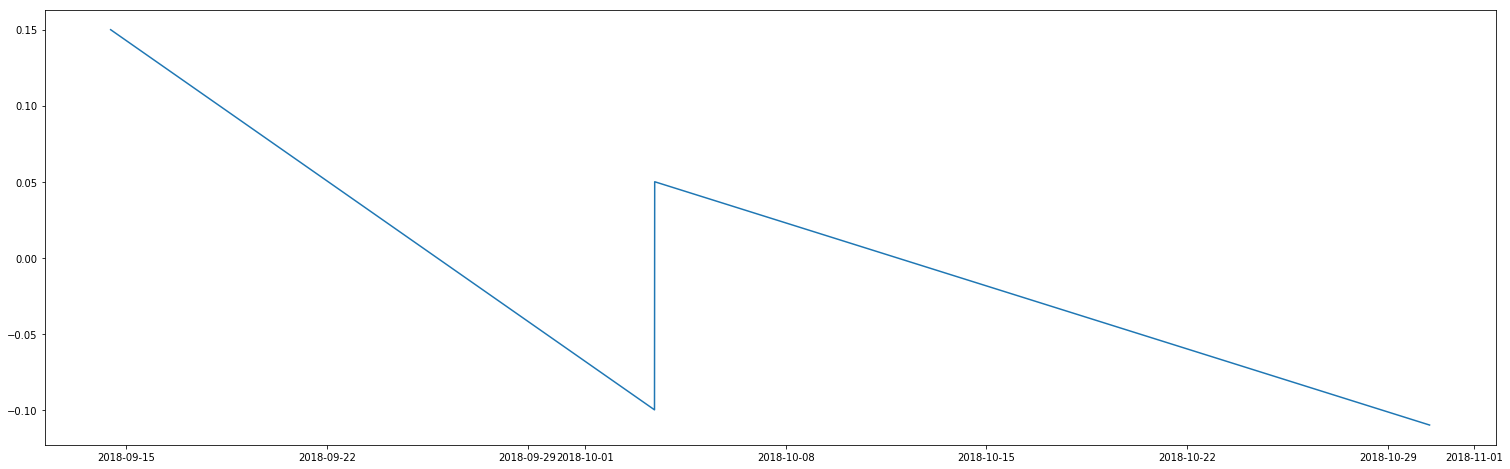

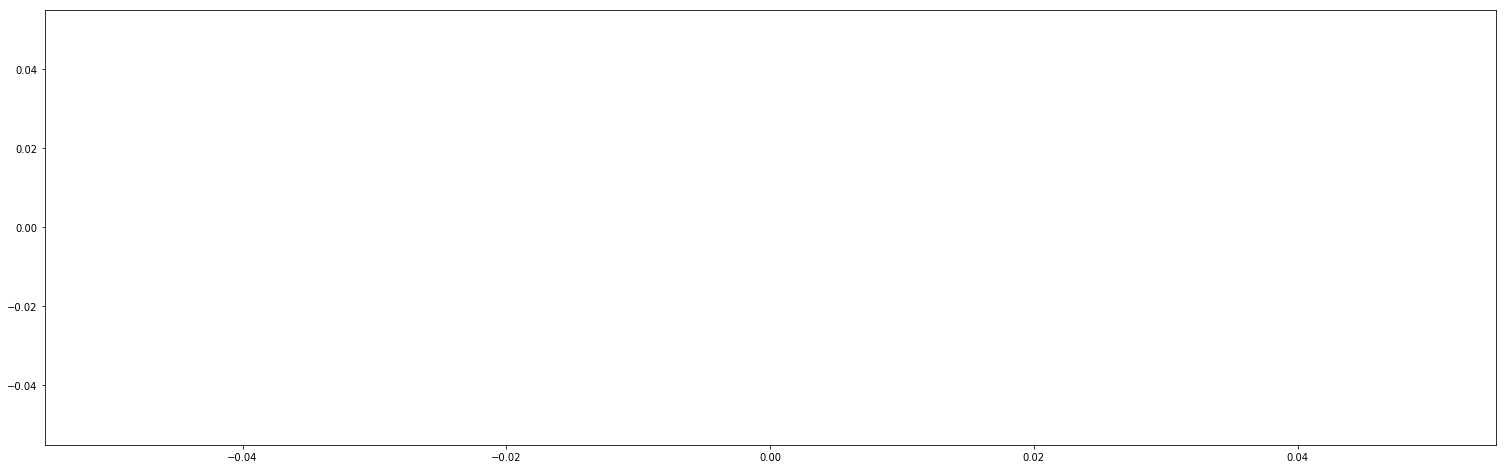

In [32]:
lgbmc = TrainModel(LGBMClassifier(learning_rate=.03, subsample=.8, max_depth=15, num_classes=5,
                                                        objective='multiclass:softmax', metric='multi_logloss',
                                                        sub_feature=.5, num_leaves=50, min_data=10, n_jobs=32), 
                         X_train, y_train_HL, X_val, y_val_HL, 
                         X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_model()

CalcResults(lgbmc, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
CalcResults(lgbmc, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
CalcResults(lgbmc, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

### HL SMOTE

In [33]:
X_train_smote, X_val_smote, y_train_smote_HL, y_val_smote_HL = create_smote_df(HL=True, need_cont_vars=False)
print(X_train_smote.shape, X_val_smote.shape, y_train_smote_HL.shape, y_val_smote_HL.shape)

Original dataset shape: Counter({2.0: 17943, 3.0: 1594, 1.0: 1575, 0.0: 232, 4.0: 188})
Resampled dataset shape: Counter({2.0: 17943, 3.0: 17943, 1.0: 17943, 0.0: 17943, 4.0: 17943})
(62800, 504) (26915, 504) (2713, 504) (62800,) (26915,) (2713,)
category    311
float32     193
dtype: int64 category    311
float32     193
dtype: int64
(62800, 504) (26915, 504) (62800,) (26915,)


Train Accuracy: 0.8462898089171974
Val Accuracy: 0.08753483187813486
Test Accuracy: 0.6310357537781054
Train F1: 0.8675098778588852
Val F1: 0.04339512290327425
Test F1: 0.6449347786719221
Train:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.89      1.00      0.94      0.94      0.87     19993
        1.0       0.89      0.76      0.95      0.82      0.85      0.71     20855
        2.0       0.94      0.88      0.98      0.91      0.93      0.85     19196
        3.0       0.29      0.95      0.90      0.45      0.92      0.86      2713
        4.0       0.23      1.00      1.00      0.37      1.00      1.00        43

avg / total       0.91      0.85      0.97      0.87      0.91      0.81     62800

Val:                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      1.00      0.00      0.00      0.00      6043
        1.0       0.00      0.00      1.00      0

,Target_HL,Test Predictions,Actual10minHighMove,Actual10minLowMove,Actual10minMove,Test P/L HL
Datetime,,,,,,
2018-11-01 12:50:00-05:00,2.0,1.0,0.06,-0.15,-0.07,0.15
2018-11-02 12:10:00-05:00,2.0,1.0,0.11,-0.07,-0.03,0.03
2018-11-08 10:40:00-06:00,3.0,1.0,0.17,-0.01,0.06,-0.06
2018-11-12 10:00:00-06:00,1.0,1.0,0.05,-0.18,-0.18,0.15
2018-11-12 10:20:00-06:00,1.0,1.0,0.06,-0.27,-0.10,0.15
2018-11-12 10:30:00-06:00,1.0,1.0,0.04,-0.17,-0.05,0.15
2018-11-12 10:50:00-06:00,2.0,1.0,0.14,0.00,0.04,-0.04
2018-11-13 09:10:00-06:00,0.0,0.0,0.04,-0.77,-0.59,0.50
2018-11-16 11:30:00-06:00,0.0,3.0,0.00,-0.66,-0.64,-0.25


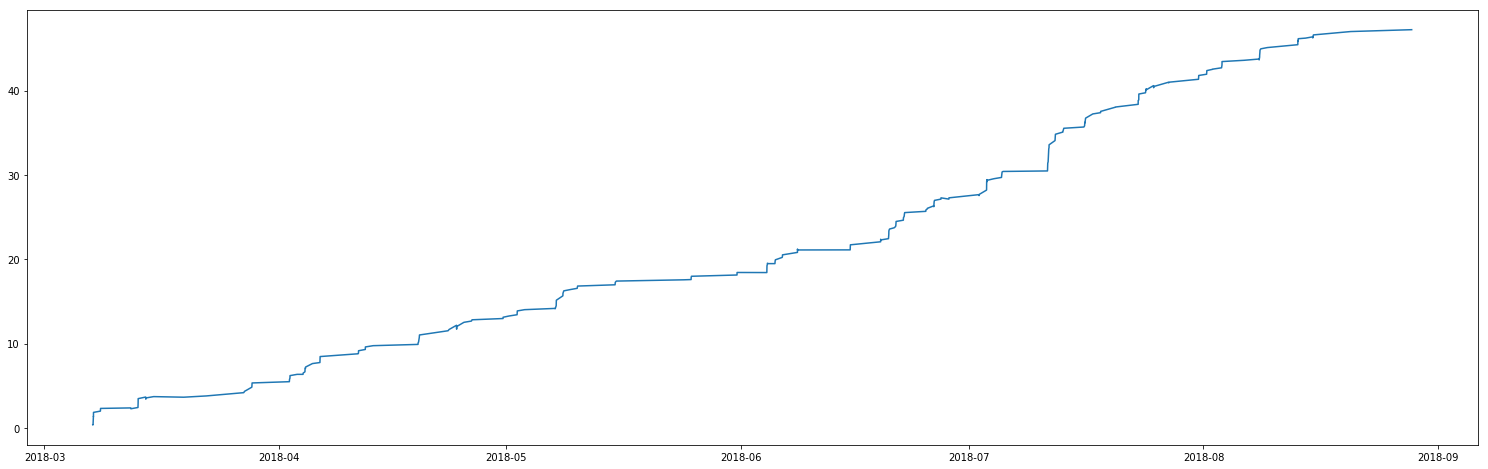

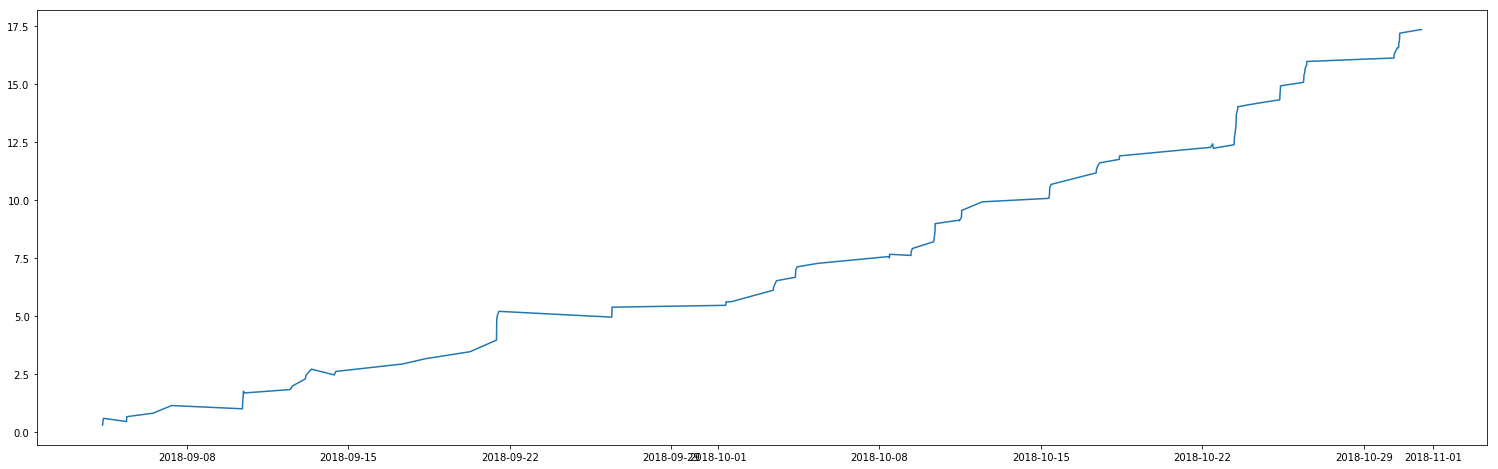

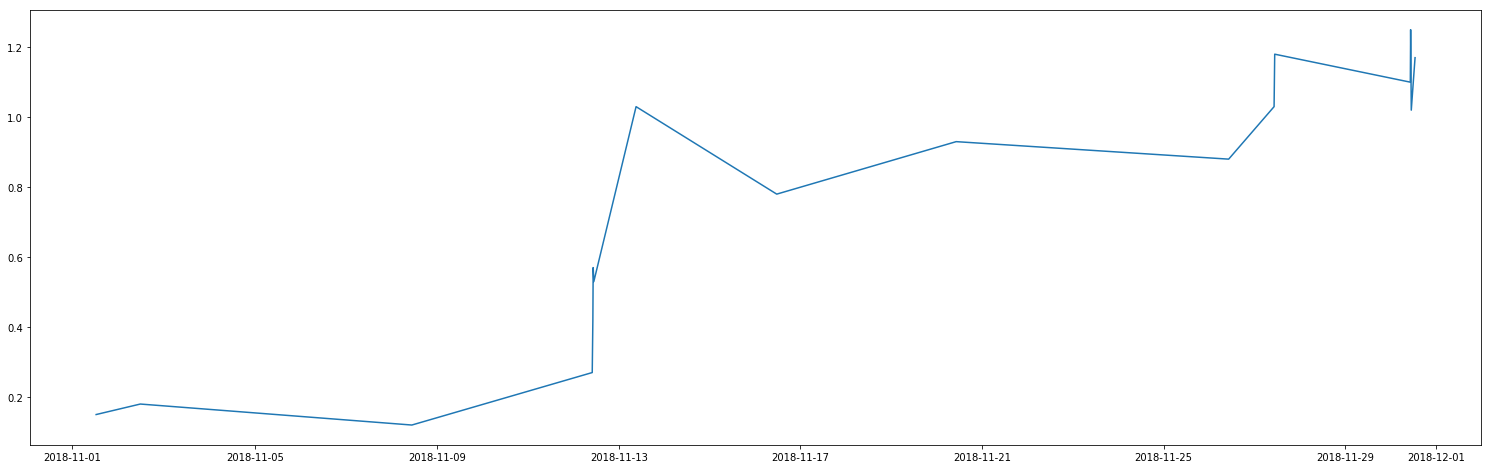

In [34]:
params = {'learning_rate':.03, 'subsample':.8, 'max_depth':15, 'num_class':5,
          'objective':'multiclass:softmax', 'metric':'multi_logloss',
          'sub_feature':.5, 'num_leaves':50, 'min_data_in_leaf':10, 'n_jobs':32}

smote_lgbmc_HL = TrainModel(LGBMClassifier(**params), 
                         X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
                         X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_model()



CalcResults(smote_lgbmc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
CalcResults(smote_lgbmc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
CalcResults(smote_lgbmc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

### Save Model

In [35]:
# import pickle
# pickle.dump(smote_lgbmc_HL, open('/home/melgazar9/Trading/Live-Trading/CL/models/CL_10min_models/SMOTE_LGBMC-HL_' + str(datetime.datetime.today().date()) + '.pickle.dat', 'wb'))

### Try SMOTE for GBMClassifier

In [36]:
# from sklearn.ensemble import GradientBoostingClassifier

# params = {'loss':'deviance', 'learning_rate':0.025, 'n_estimators':350, 'subsample':.6, 'criterion':'friedman_mse', 'min_samples_split':7,
#            'min_samples_leaf':8, 'min_weight_fraction_leaf':0.0, 'max_depth':4,
#            'max_features':90, 'verbose':0, 'max_leaf_nodes':200, 'warm_start':False, 'presort':'auto',
#            'validation_fraction':0.1, 'n_iter_no_change':5, 'tol':0.0001, 'random_state':0}




# smote_gbmc_HL = TrainModel(GradientBoostingClassifier(**params), 
#                            X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
#                            X_test, y_test_HL, 
#                            need_cont_vars=False, plot_importances=False).train_model()


# CalcResults(smote_gbmc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.22, med_cap=.12, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(smote_gbmc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.22, med_cap=.12, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(smote_gbmc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.22, med_cap=.12, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

# Neural Networks

#### Scale smote dataframes for y_actual and y_HL

In [37]:
X_train_smote_scaled, X_val_smote_scaled, y_train_smote_actual, y_val_smote_actual = create_smote_df(HL=False, need_cont_vars=False, scale=True)

X_train_smote_scaled, X_val_smote_scaled, y_train_smote_HL, y_val_smote_HL = create_smote_df(HL=True, need_cont_vars=False, scale=True)

Original dataset shape: Counter({2.0: 19871, 3.0: 744, 1.0: 712, 0.0: 111, 4.0: 94})
Resampled dataset shape: Counter({2.0: 19871, 3.0: 19871, 1.0: 19871, 0.0: 19871, 4.0: 19871})
(69548, 504) (29807, 504) (2713, 504) (69548,) (29807,) (2713,)
category    311
float32     193
dtype: int64 category    311
float32     193
dtype: int64


#### Convert targets to one-hot encoded categorical targets

In [39]:
y_train_smote_oh_HL = keras.utils.to_categorical(y_train_smote_HL)
y_val_smote_oh_HL = keras.utils.to_categorical(y_val_smote_HL)
y_val_smote_oh_HL

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Feed Forward Network (MLP)

Epoch 1/1
16145/16145 [==============================] - 5s 328us/step - loss: 0.6107 - categorical_accuracy: 0.8320
Train Accuracy: 0.8376587178693093
Val Accuracy: 0.8201225171709672
Test Accuracy: 0.680796166605234
Train F1: 0.9115764246032266
Val F1: 0.9011728709841917
Test F1: 0.8100877192982456
Train:                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      0.99      0.00      0.00      0.00         0
          1       0.00      0.00      0.93      0.00      0.00      0.00         0
          2       1.00      0.84      0.50      0.91      0.65      0.43     16143
          3       0.00      0.00      0.93      0.00      0.00      0.00         2
          4       0.00      0.00      0.99      0.00      0.00      0.00         0

avg / total       1.00      0.84      0.50      0.91      0.65      0.43     16145

Val:                    pre       rec       spe        f1       geo       iba       sup

          0       

,Target_HL,Test Predictions,Actual10minHighMove,Actual10minLowMove,Actual10minMove,Test P/L HL
Datetime,,,,,,


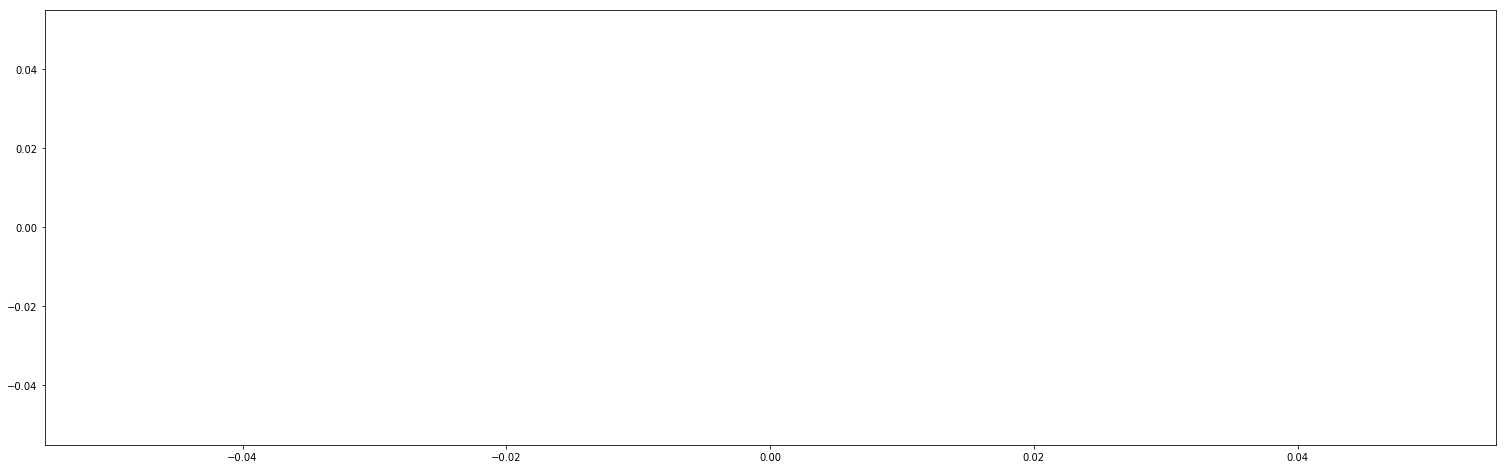

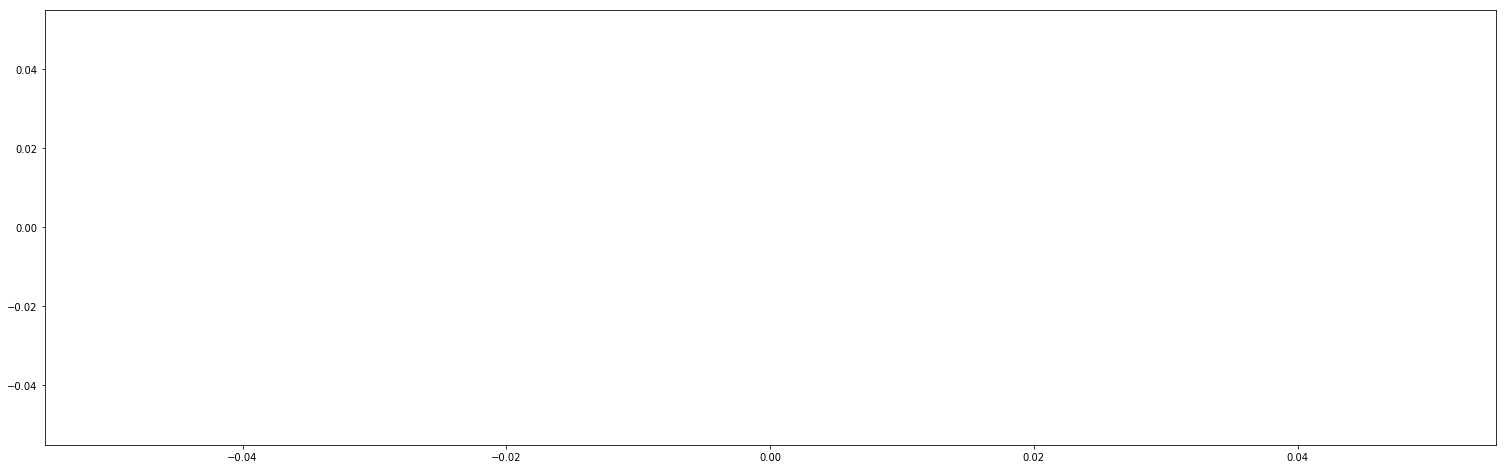

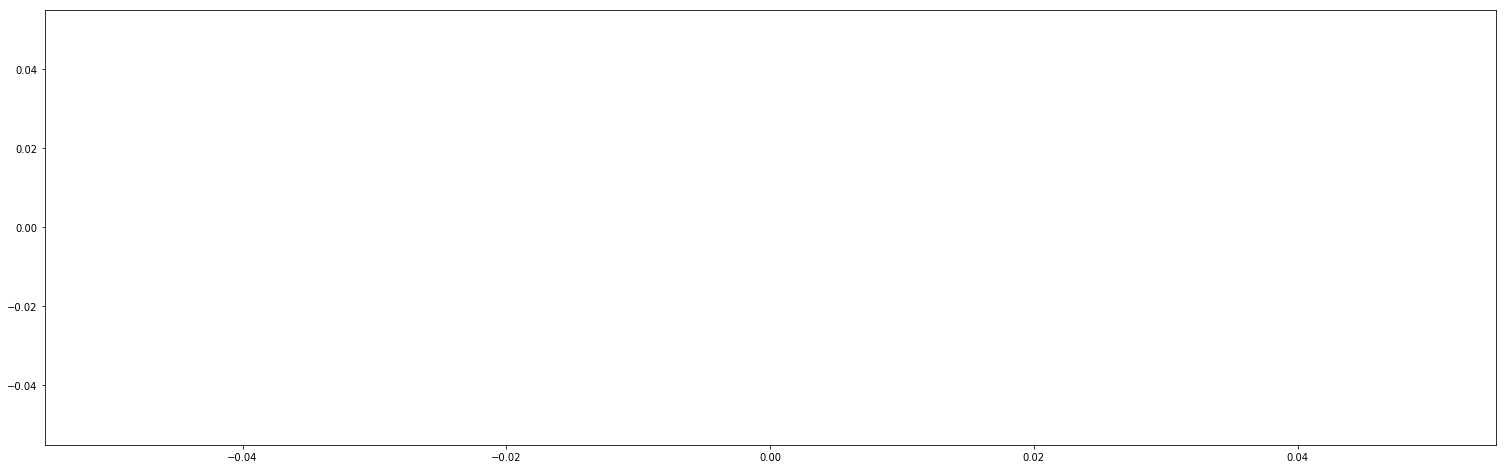

In [116]:
inputs = Input(shape=(X_train.shape[1],))

hidden = Dense(units=10, activation='relu',)(inputs)
hidden = Dense(units=10, activation='relu')(hidden)
predictions = Dense(5, activation='softmax')(hidden)

# #optimizer = SGD(lr=0.0005, momentum=.999, decay=0.9, nesterov=True)
optimizer = Adam(lr=0.001, epsilon=1e-8)

model = Model(inputs=inputs, outputs=predictions)


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model = TrainModel(model, X_train_scaled, y_train_oh_HL, X_val_scaled, y_val_oh_HL, 
                   X_test_scaled, y_test_oh_HL, need_cont_vars=False, NN=True, epochs=1).train_model()

CalcResults(model, X_train_scaled, y_train_oh_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, 
            med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True, NN=True).calc_results()
CalcResults(model, X_val_scaled, y_val_oh_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, 
            med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True, NN=True).calc_results()
CalcResults(model, X_test_scaled, y_test_oh_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, 
            med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True, NN=True).calc_results()

### LSTM RAW

In [135]:
X_train_reshaped = np.array(X_train_scaled, dtype='float32').reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = np.array(X_val_scaled, dtype='float32').reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = np.array(X_test_scaled, dtype='float32').reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

inputs = Input(shape=(X_train_scaled.shape[1], 1,))

hidden = LSTM(units=10, activation='tanh')(inputs)
hidden = Dense(units=10, activation='relu')(hidden)
predictions = Dense(5, activation='softmax')(hidden)

# #optimizer = SGD(lr=0.0005, momentum=.999, decay=0.9, nesterov=True)
optimizer = Adam(lr=0.001, epsilon=1e-8)

model = Model(inputs=inputs, outputs=predictions)


model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model = TrainModel(model, X_train_reshaped, y_train_oh_HL, X_val_reshaped, y_val_oh_HL, 
                   X_test_reshaped, y_test_oh_HL, need_cont_vars=False, NN=True, epochs=1).train_model()

CalcResults(model, X_train_scaled, y_train_oh_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, 
            med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True, NN=True).calc_results()
CalcResults(model, X_val_scaled, y_val_oh_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, 
            med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True, NN=True).calc_results()
CalcResults(model, X_test_scaled, y_test_oh_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, 
            med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True, NN=True).calc_results()

<bound method Network.summary of <keras.engine.training.Model object at 0x7fea5e9bf748>>
Epoch 1/1


KeyboardInterrupt: 

In [143]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=128, input_length=X_train_scaled.shape[1], dropout=0.2))
model.add(LSTM(units=50, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(units=5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 504, 128)          12800     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                35800     
_________________________________________________________________
dense_144 (Dense)            (None, 5)                 255       
Total params: 48,855
Trainable params: 48,855
Non-trainable params: 0
_________________________________________________________________


In [144]:
model.fit(X_train_scaled, y_train_oh_HL, batch_size=512, epochs=5)

Epoch 1/5
16145/16145 [==============================] - 26s 2ms/step - loss: 1.0116 - acc: 0.7792
Epoch 2/5
16145/16145 [==============================] - 24s 1ms/step - loss: 0.6183 - acc: 0.8377
Epoch 3/5
16145/16145 [==============================] - 23s 1ms/step - loss: 0.6142 - acc: 0.8377
Epoch 4/5
16145/16145 [==============================] - 23s 1ms/step - loss: 0.6139 - acc: 0.8377
Epoch 5/5
16145/16145 [==============================] - 24s 1ms/step - loss: 0.6140 - acc: 0.8377


In [148]:
predictions = model.predict(X_train_scaled).argmax(axis=-1)

print(classification_report_imbalanced(predictions, y_train_oh_HL.argmax(axis=-1)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      0.99      0.00      0.00      0.00         0
          1       0.00      0.00      0.93      0.00      0.00      0.00         0
          2       1.00      0.84      0.00      0.91      0.00      0.00     16145
          3       0.00      0.00      0.93      0.00      0.00      0.00         0
          4       0.00      0.00      0.99      0.00      0.00      0.00         0

avg / total       1.00      0.84      0.00      0.91      0.00      0.00     16145



In [149]:
model.fit(X_train_smote_scaled, y_train_smote_oh_HL, batch_size=512, epochs=5)

Epoch 1/5
62800/62800 [==============================] - 91s 1ms/step - loss: 1.4292 - acc: 0.3207
Epoch 2/5
62800/62800 [==============================] - 91s 1ms/step - loss: 1.2885 - acc: 0.4143
Epoch 3/5
62800/62800 [==============================] - 90s 1ms/step - loss: 1.2566 - acc: 0.4295
Epoch 4/5
62800/62800 [==============================] - 91s 1ms/step - loss: 1.2430 - acc: 0.4391
Epoch 5/5
62800/62800 [==============================] - 91s 1ms/step - loss: 1.2460 - acc: 0.4384


In [151]:
predictions_train = model.predict(X_train_scaled).argmax(axis=-1)
predictions_val = model.predict(X_val_scaled).argmax(axis=-1)
predictions_test = model.predict(X_test_scaled).argmax(axis=-1)

print(classification_report_imbalanced(predictions_train, y_train_oh_HL.argmax(axis=-1)))
print(classification_report_imbalanced(predictions_val, y_val_oh_HL.argmax(axis=-1)))
print(classification_report_imbalanced(predictions_test, y_test_oh_HL.argmax(axis=-1)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.08      0.04      0.99      0.05      0.20      0.03       337
          1       0.28      0.10      0.94      0.15      0.30      0.08      3181
          2       0.81      0.86      0.26      0.83      0.47      0.23     12627
          3       0.00      0.00      0.93      0.00      0.00      0.00         0
          4       0.00      0.00      0.99      0.00      0.00      0.00         0

avg / total       0.69      0.70      0.41      0.68      0.43      0.20     16145

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      0.99      0.00      0.00      0.00         0
          1       0.07      0.23      0.92      0.11      0.47      0.20       132
          2       0.99      0.83      0.57      0.90      0.69      0.48      5255
          3       0.00      0.00      0.93      0.00      0.00      0.00         0


In [233]:
# from logitboost import LogitBoost
# from sklearn.ensemble import RandomForestRegressor


# rfr_params = {'n_estimators':100, 'criterion':'mse', 'max_depth':3, 'min_samples_split':3, 
#               'min_samples_leaf'=1, 'min_weight_fraction_leaf'=0.0, 'max_features'=’auto’, 
#               'max_leaf_nodes'=None, min_impurity_decrease=0.0, 'bootstrap'=True,
#               'oob_score'=True, 'n_jobs'=32, 'random_state'=0, 'verbose'=0, 'warm_start'=True}



# base_estimator=RandomForestRegressor(**rfr_params)


# logitc_HL = TrainModel(LogitBoost(base_estimator=base_estimator), 
#                        X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
#                        X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_ML_model()


# CalcResults(logitc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/melgazar9/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-233-7b0fe154c752>", line 7, in <module>
    X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_traditional_ML_model()
  File "<ipython-input-26-59c8ecab4dfd>", line 51, in train_traditional_ML_model
    self.model.fit(self.X_train_fit, self.y_train_fit)
  File "/home/melgazar9/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/logitboost/logitboost.py", line 169, in fit
    return self._fit_multiclass(X, y, random_state, fit_params)
  File "/home/melgazar9/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/logitboost/logitboost.py", line 427, in _fit_multiclass
    fit_params)
  File "/home/melgazar9/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/logitboost/logitboost.py", line 472, in _boost_multiclass
    estimator.fit(X_tr

KeyboardInterrupt: 

In [ ]:
# rfr_params = {'n_estimators':100, 'criterion':'mse', 'max_depth':3, 'min_samples_split':3, 
#               'min_samples_leaf'=1, 'min_weight_fraction_leaf'=0.0, 'max_features':'auto', 
#               'max_leaf_nodes':None, 'min_impurity_decrease':0.0, 'bootstrap':True,
#               'oob_score':True, 'n_jobs':32, 'random_state':0, 'verbose':0, 'warm_start':True}


# base_estimator=RandomForestRegressor(**rfr_params)


# logitc_HL = TrainModel(LogitBoost(base_estimator=base_estimator), 
#                          X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
#                          X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_model()


# CalcResults(logitc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

In [ ]:
# rfr_params = {'n_estimators':100, 'criterion':'mse', 'max_depth':3, 'min_samples_split':3, 
#               'min_samples_leaf'=1, 'min_weight_fraction_leaf'=0.0, 'max_features':'auto', 
#               'max_leaf_nodes':None, 'min_impurity_decrease':0.0, 'bootstrap':True,
#               'oob_score':True, 'n_jobs':32, 'random_state':0, 'verbose':0, 'warm_start':False}



# base_estimator=RandomForestRegressor(**rfr_params)


# logitc_HL = TrainModel(LogitBoost(base_estimator=base_estimator), 
#                          X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
#                          X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_model()


# CalcResults(logitc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

In [ ]:
# rfr_params = {'n_estimators':100, 'criterion':'mse', 'max_depth':3, 'min_samples_split':3, 
#               'min_samples_leaf'=10, 'min_weight_fraction_leaf'=0.0, 'max_features':90, 
#               'max_leaf_nodes':None, 'min_impurity_decrease':0.0, 'bootstrap':True,
#               'oob_score':True, 'n_jobs':32, 'random_state':0, 'verbose':0, 'warm_start':True}



# base_estimator=RandomForestRegressor(**rfr_params)


# logitc_HL = TrainModel(LogitBoost(base_estimator=base_estimator), 
#                          X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
#                          X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_model()


# CalcResults(logitc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

In [ ]:
# rfr_params = {'n_estimators':100, 'criterion':'mse', 'max_depth':3, 'min_samples_split':3, 
#               'min_samples_leaf'=10, 'min_weight_fraction_leaf'=0.0, 'max_features':90, 
#               'max_leaf_nodes':None, 'min_impurity_decrease':0.0, 'bootstrap':True,
#               'oob_score':False, 'n_jobs':32, 'random_state':0, 'verbose':0, 'warm_start':True}



# base_estimator=RandomForestRegressor(**rfr_params)


# logitc_HL = TrainModel(LogitBoost(base_estimator=base_estimator), 
#                          X_train_smote, y_train_smote_HL, X_val_smote, y_val_smote_HL, 
#                          X_test, y_test_HL, need_cont_vars=False, plot_importances=False).train_model()


# CalcResults(logitc_HL, X_train, y_train_HL, predictions='Train Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_val, y_val_HL, predictions='Val Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()
# CalcResults(logitc_HL, X_test, y_test_HL, predictions='Test Predictions', stop=.25, strong_cap=.5, med_cap=.15, multiplier=1000, need_cont_vars=False, HL=True).calc_results()

In [198]:
# import math
# import numpy as np
# from scipy import special
# import random
# import copy as cp
# from sklearn.tree import DecisionTreeClassifier

# class BrownBoost:
#     def __init__(self, base_estimator, c=10, convergence_criterion=0.0001, max_iter=10000):
#         """ Initiates BrownBoost classifier
        
#         Parameters
#         ----------
#         base_estimator: classifier from scikit-learn
#             The base leaner in ensemble
#         c: int or float
#             A positive real value
#             default = 10
#         convergence_criterion: float
#             A small constant(>0) used to avoid degenerate cases.
#             default = 0.0001
#         """
#         self.base_estimator = base_estimator
#         self.c = c
#         self.max_iter = max_iter
#         self.max_iter_newton_raphson = max_iter / 100
#         self.convergence_criterion = convergence_criterion
#         self.alphas = []
#         self.hs = []
#         self.ss = []
        
        
#     def fit(self, X, y):
#         """ Trains the classifier
#         Parameters
#         ----------
#         X: ndarray
#             The training instances
#         y: ndarray
#             The target values for The training instances
            
#         returns
#         --------
#             self
#         """

#         # Initiate parameters
#         self.__init__(base_estimator=self.base_estimator,
#                       c=self.c,
#                       max_iter=self.max_iter,
#                       convergence_criterion=self.convergence_criterion)

#         s = self.c
#         r = np.zeros(X.shape[0])
#         k = 0
#         while s >= 0 and k < self.max_iter :
# #             print(f'iter is {k}\ts = {s}')
#             self.ss.append(s)
#             k += 1
#             w = np.exp(-(r + s)**2 / self.c)

#             h = cp.deepcopy(self.base_estimator)
#             h.fit(X, y, sample_weight=w)
#             pred = h.predict(X)
            
#             error = np.multiply(pred, y)
#             gamma = np.dot(w, error)

#             alpha, t = self.newton_raphson(r, error, s, gamma)
# #             theta = (0.1/self.c)**2
# #             A = 32 * math.sqrt(self.c*math.log(2/theta))
# #             if t < gamma**2/A:
# #                 (new_t * w).sum()
# #                 t = new_t + gamma**2/A

#             r += alpha * error
#             s -= t

#             self.alphas.append(alpha)
#             self.hs.append(h)

#     def predict(self, X):
#         """ Classify the samples
#         Parameters
#         ----------
#         X: ndarray
#             The test instances
            
#         Returns
#         -------
#         y: ndarray
#             The pred with BrownBoost for the test instances
#         """

#         y = np.zeros(X.shape[0])
#         for i in range(0, len(self.hs)):
#             y += self.alphas[i] * self.hs[i].predict(X)
#         return np.sign(y)

#     def newton_raphson(self, r, error, s, gamma):
#         """ Computes alpha and t
#         Parameters
#         ----------
#         r: array
#             margins for the instances
#         error: ndarray
#             error vec between pred and true instances
#         s: float
#             'time remaining'
#         gamma: float
#             correlation
#         y: ndarray
#             the target values
            
#         Retruns
#         -------
#         alpha: float
#         t: float
#         """

#         # Theorem 3 & 5
#         alpha = min([0.1, gamma])
#         t = (alpha**2) / 3

#         a = r + s
#         change_amount = self.convergence_criterion + 1
#         k = 0

#         while change_amount > self.convergence_criterion and k < self.max_iter_newton_raphson:
#             d = a + alpha * error - t
#             w = np.exp(-d**2 / self.c)

#             # Coefficients for jacobian
#             W = w.sum()
#             U = (w * d * error).sum()
#             B = (w * error).sum()
# #             if abs(B) < 0.001:
# #                 break
#             V = (w * d * error**2).sum()
#             E = (special.erf(d / math.sqrt(self.c)) - special.erf(a / math.sqrt(self.c))).sum()

#             sqrt_pi_c = math.sqrt(math.pi * self.c)
#             denominator = 2*(V*W - U*B)
#             alpha_step = (self.c*W*B + sqrt_pi_c*U*E)/denominator
#             t_step = (self.c*B*B + sqrt_pi_c*V*E)/denominator

#             alpha += alpha_step
#             t += t_step
#             change_amount = math.sqrt(alpha_step**2 + t_step**2)
# #             print(f'\t newton_raphson iter is {k}, {change_amount}')
#             k += 1
#         return alpha, t

    


In [199]:
# base_estimator = DecisionTreeClassifier(max_depth=1)
# clf = BrownBoost(base_estimator, c=1)
# clf.fit(X_train, y_train_HL)